# How To Train Model for Open Book Q&A Technique - Part 2
The notebook you are reading is a fork of Mgoksu's great notebook [here][1]. Mgoksu (@mgoksu) demonstrated how to achieve top public LB=0.807 using Open Book technique. The Open Book method was first presented by JJ (@jjinho) [here][2], then Quangteo (@quangbk) improved RAM usage [here][3], and Anil (@nlztrk) combined with Q&A [here][4]. Radek (@radek1) demonstrated the strength of Q&A [here][5].

In my previous notebook [here][6] (i.e. Part 1), we demonstrated how to train a model for Open Book. The model was trained using my 60k Kaggle dataset [here][7]. If you enjoy the notebook you are reading, please upvote the dataset too. Thanks!

In this notebook, we will load the trained model output from my previous notebook. We will infer this model after running the code from Mgoksu's public notebook to use Open Book to seach Wikipedia for context. For each test sample in the hidden dataset, we will append Wikipedia context. Then our trained model will infer the multiple choice answer (using both question and appended Wikipedia context). When predicting the answer, this notebook uses a 50% 50% ensemble of the new Q&A model we trained ensembled with Mgoksu's original model. Here is a diagram showing the Open Book method:

![](https://miro.medium.com/v2/resize:fit:800/format:webp/1*bTGY3fKIgNefQxNsOYpnBw.png)

(image source [here][8])

[1]: https://www.kaggle.com/code/mgoksu/0-807-sharing-my-trained-with-context-model
[2]: https://www.kaggle.com/code/jjinho/open-book-llm-science-exam
[3]: https://www.kaggle.com/code/quangbk/open-book-llm-science-exam-reduced-ram-usage
[4]: https://www.kaggle.com/code/nlztrk/openbook-debertav3-large-baseline-single-model
[5]: https://www.kaggle.com/code/radek1/new-dataset-deberta-v3-large-training
[6]: https://www.kaggle.com/code/cdeotte/how-to-train-open-book-model
[7]: https://www.kaggle.com/datasets/cdeotte/60k-data-with-context-v2
[8]: https://blog.gopenai.com/enrich-llms-with-retrieval-augmented-generation-rag-17b82a96b6f0

In [1]:

RUN_ON_KAGGLE = False


TOP_N_PAGES = 5
NUM_SENTENCES_INCLUDE = 100

# OpenBook DeBERTaV3-Large with an updated model

This work is based on the great [work](https://www.kaggle.com/code/nlztrk/openbook-debertav3-large-baseline-single-model) of [nlztrk](https://www.kaggle.com/nlztrk).

I trained a model offline using the dataset I shared [here](https://www.kaggle.com/datasets/mgoksu/llm-science-exam-dataset-w-context). I just added my model to the original notebook. The model is available [here](https://www.kaggle.com/datasets/mgoksu/llm-science-run-context-2).

I also addressed the problem of [CSV Not Found at submission](https://www.kaggle.com/competitions/kaggle-llm-science-exam/discussion/434228) with this notebook by clipping the context like so:

`test_df["prompt"] = test_df["context"].apply(lambda x: x[:1500]) + " #### " +  test_df["prompt"]`

You can probably get more than 1500 without getting an OOM.

In [2]:
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
from __future__ import annotations

from collections.abc import Iterable

import faiss
from faiss import write_index, read_index

from sentence_transformers import SentenceTransformer

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")

from dataclasses import dataclass
from typing import Optional, Union

import torch
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.9
CUDA SETUP: Detected CUDA version 121
CUDA SETUP: Loading binary /home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda121.so...


/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /home/viktor/miniconda3/envs/torch-env did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/home/viktor/miniconda3/envs/torch-env/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)


In [3]:
def process_documents(documents: Iterable[str],
                      document_ids: Iterable,
                      split_sentences: bool = True,
                      filter_len: int = 3,
                      disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Main helper function to process documents from the EMR.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param document_type: String denoting the document type to be processed
    :param document_sections: List of sections for a given document type to process
    :param split_sentences: Flag to determine whether to further split sections into sentences
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """
    
    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    if split_sentences:
        df = sentencize(df.text.values, 
                        df.document_id.values,
                        df.offset.values, 
                        filter_len, 
                        disable_progress_bar)
    return df


def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Obtains the sections of the imaging reports and returns only the 
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM).

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df


def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = 3,
               disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Split a document into sentences. Can be used with `sectionize_documents`
    to further split documents into more manageable pieces. Takes in offsets
    to ensure that after splitting, the sentences can be matched to the
    location in the original documents.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param offsets: Iterable tuple of the start and end indices
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents), disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1]-o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0]+offset[0], o[1]+offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)

In [4]:
if RUN_ON_KAGGLE:
    SIM_MODEL = '/kaggle/input/sentencetransformers-allminilml6v2/sentence-transformers_all-MiniLM-L6-v2'
else:
    SIM_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 16

if RUN_ON_KAGGLE:
    WIKI_PATH = "/kaggle/input/wikipedia-20230701"
else:
    WIKI_PATH = "/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index"
wiki_files = os.listdir(WIKI_PATH)

# Relevant Title Retrieval

In [5]:
if RUN_ON_KAGGLE:
    trn = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv").drop("id", 1)
else:
    trn = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-llm-science-exam/train.csv", index_col="id")
    # trn = pd.read_csv("/home/viktor/Documents/kaggle/kaggle_llm/data/data_dumps/more_questions/more_questions_raw_questions_wiki_sci_3.csv", index_col="id").sample(n=2048).reset_index(drop=True)
    trn = trn[trn['answer'].isin(['A', 'B', 'C', 'D', 'E'])].reset_index(drop=True)
    # "Unnamed: 0" to "id"
    # trn = trn.rename(columns={"Unnamed: 0": "id"})
    
    
trn.head()

,prompt,A,B,C,D,E,answer
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D


In [6]:
model = SentenceTransformer(SIM_MODEL, device='cuda')
model.max_seq_length = MAX_LENGTH
model = model.half()

In [7]:

if RUN_ON_KAGGLE:
    sentence_index = read_index("/kaggle/input/wikipedia-2023-07-faiss-index/wikipedia_202307.index")
else:
    sentence_index = read_index("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index-2/wikipedia_202307.index")

In [8]:
prompt_embeddings = model.encode(trn.prompt.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
prompt_embeddings = prompt_embeddings.detach().cpu().numpy()
_ = gc.collect()

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

In [9]:
## Get the top 3 pages that are likely to contain the topic of interest
search_score, search_index = sentence_index.search(prompt_embeddings, TOP_N_PAGES)

In [10]:
## Save memory - delete sentence_index since it is no longer necessary
del sentence_index
del prompt_embeddings
_ = gc.collect()
libc.malloc_trim(0)

1

# Getting Sentences from the Relevant Titles

In [11]:
if RUN_ON_KAGGLE:
    df = pd.read_parquet("/kaggle/input/wikipedia-20230701/wiki_2023_index.parquet", columns=['id', 'file'])
else:
    df = pd.read_parquet("/home/viktor/Documents/kaggle/kaggle_llm/data/kaggle-datasets/wikipedia-2023-07-faiss-index/wiki_2023_index.parquet", columns=['id', 'file'])

In [12]:
## Get the article and associated file location using the index
wikipedia_file_data = []

for i, (scr, idx) in tqdm(enumerate(zip(search_score, search_index)), total=len(search_score)):
    scr_idx = idx
    _df = df.loc[scr_idx].copy()
    _df['prompt_id'] = i
    wikipedia_file_data.append(_df)
wikipedia_file_data = pd.concat(wikipedia_file_data).reset_index(drop=True)
wikipedia_file_data = wikipedia_file_data[['id', 'prompt_id', 'file']].drop_duplicates().sort_values(['file', 'id']).reset_index(drop=True)

## Save memory - delete df since it is no longer necessary
del df
_ = gc.collect()
libc.malloc_trim(0)

  0%|          | 0/200 [00:00<?, ?it/s]

1

In [13]:
## Get the full text data
wiki_text_data = []

for file in tqdm(wikipedia_file_data.file.unique(), total=len(wikipedia_file_data.file.unique())):
    _id = [str(i) for i in wikipedia_file_data[wikipedia_file_data['file']==file]['id'].tolist()]
    _df = pd.read_parquet(f"{WIKI_PATH}/{file}", columns=['id', 'text'])

    _df_temp = _df[_df['id'].isin(_id)].copy()
    del _df
    _ = gc.collect()
    libc.malloc_trim(0)
    wiki_text_data.append(_df_temp)
wiki_text_data = pd.concat(wiki_text_data).drop_duplicates().reset_index(drop=True)
_ = gc.collect()

  0%|          | 0/28 [00:00<?, ?it/s]

In [14]:
## Parse documents into sentences
processed_wiki_text_data = process_documents(wiki_text_data.text.values, wiki_text_data.id.values)

  0%|          | 0/954 [00:00<?, ?it/s]

  0%|          | 0/954 [00:00<?, ?it/s]

In [15]:
## Get embeddings of the wiki text data
wiki_data_embeddings = model.encode(processed_wiki_text_data.text,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE,
                                    show_progress_bar=True,
                                    convert_to_tensor=True,
                                    normalize_embeddings=True)#.half()
wiki_data_embeddings = wiki_data_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/3166 [00:00<?, ?it/s]

In [16]:
_ = gc.collect()

In [17]:
## Combine all answers
trn['answer_all'] = trn.apply(lambda x: " ".join([x['A'], x['B'], x['C'], x['D'], x['E']]), axis=1)


## Search using the prompt and answers to guide the search
trn['prompt_answer_stem'] = trn['prompt'] + " " + trn['answer_all']

In [18]:
question_embeddings = model.encode(trn.prompt_answer_stem.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
question_embeddings = question_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

# Extracting Matching Prompt-Sentence Pairs

In [19]:
## Parameter to determine how many relevant sentences to include


## List containing just Context
contexts = []

for r in tqdm(trn.itertuples(), total=len(trn)):

    prompt_id = r.Index

    prompt_indices = processed_wiki_text_data[processed_wiki_text_data['document_id'].isin(wikipedia_file_data[wikipedia_file_data['prompt_id']==prompt_id]['id'].values)].index.values

    if prompt_indices.shape[0] > 0:
        prompt_index = faiss.index_factory(wiki_data_embeddings.shape[1], "Flat")
        prompt_index.add(wiki_data_embeddings[prompt_indices])

        context = ""
        
        ## Get the top matches
        ss, ii = prompt_index.search(question_embeddings, NUM_SENTENCES_INCLUDE)
        for _s, _i in zip(ss[prompt_id], ii[prompt_id]):
            context += processed_wiki_text_data.loc[prompt_indices]['text'].iloc[_i] + " "
        
    contexts.append(context)

  0%|          | 0/200 [00:00<?, ?it/s]

In [20]:
trn['context'] = contexts

In [21]:
if 'answer' in trn.columns:
    trn[["prompt", "context", "A", "B", "C", "D", "E", 'answer']].to_csv("./test_context.csv", index=False)
else:
    trn[["prompt", "context", "A", "B", "C", "D", "E"]].to_csv("./test_context.csv", index=False)

# Inference

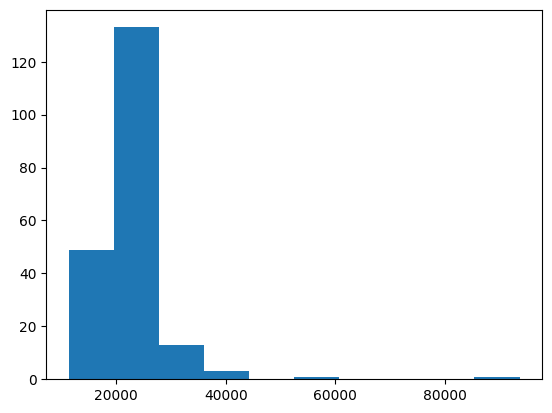

In [22]:
test_df = pd.read_csv("test_context.csv")
test_df['context_len'] = test_df['context'].apply(lambda x: len(x))
import matplotlib.pyplot as plt

plt.hist(test_df['context_len'], bins=10);

In [23]:
test_df

,prompt,context,A,B,C,D,E,answer,context_len
0,Which of the following statements accurately d...,The presence of a clustered thick disk-like co...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...,D,17415
1,Which of the following is an accurate definiti...,Many of these systems evolve in a self-similar...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,A,19352
2,Which of the following statements accurately d...,It is possible that this usage is related with...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...,A,22086
3,What is the significance of regularization in ...,Renormalization is distinct from regularizatio...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,C,23114
4,Which of the following statements accurately d...,Several qualitative observations can be made o...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,D,24929
...,...,...,...,...,...,...,...,...,...
195,What is the relation between the three moment ...,The second equation is more general as it does...,The three moment theorem expresses the relatio...,The three moment theorem is used to calculate ...,The three moment theorem describes the relatio...,The three moment theorem is used to calculate ...,The three moment theorem is used to derive the...,C,26520
196,"What is the throttling process, and why is it ...",A throttle is the mechanism by which fluid flo...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,The throttling process is a steady adiabatic f...,The throttling process is a steady flow of a f...,The throttling process is a steady adiabatic f...,B,24122
197,What happens to excess base metal as a solutio...,"Furthermore, this melting may begin at a tempe...","The excess base metal will often solidify, bec...",The excess base metal will often crystallize-o...,"The excess base metal will often dissolve, bec...","The excess base metal will often liquefy, beco...","The excess base metal will often evaporate, be...",B,21703
198,"What is the relationship between mass, force, ...",Newton first set out the definition of mass Th...,Mass is a property that determines the weight ...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is an inertial property that determines a...,Mass is a property that determines the size of...,D,27594


In [24]:
test_df = pd.read_csv("test_context.csv")
test_df.index = list(range(len(test_df)))
test_df['id'] = list(range(len(test_df)))


def split_prompt(prompt, max_size=400): 
    """
    Splits a given prompt into chunks of size max_size.
    """
    return [prompt[i:i+max_size] for i in range(0, len(prompt), max_size)]

# Apply the split_prompt function to each row in the "prompt" column
test_df["context"] = test_df["context"].apply(lambda x: split_prompt(x))

# Explode the "prompt" column
test_df = test_df.explode("context", ignore_index=True)


test_df["prompt"] =  test_df["prompt"] + " #### " + test_df["context"]

if 'answer' not in test_df.columns:
    test_df['answer'] = 'A'

In [25]:
if RUN_ON_KAGGLE:
    model_dir = "/kaggle/input/llm-science-run-context-2"
else:
    model_dir ="/home/viktor/Documents/kaggle/kaggle_llm/work_dirs/160k-viktor-and-deotte-dataset-deotte-preproc-deberta/deberta-v3-large-2023-09-17-10-00-20/checkpoint-14400"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [26]:
# We'll create a dictionary to convert option names (A, B, C, D, E) into indices and back again
options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # The AutoModelForMultipleChoice class expects a set of question/answer pairs
    # so we'll copy our question 5 times before tokenizing
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    # Our tokenizer will turn our text into token IDs BERT can understand
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [27]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [28]:
tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
# tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/11404 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [29]:
test_predictions = []
for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions.append(outputs.logits.cpu().detach())

test_predictions = torch.cat(test_predictions)
test_predictions = test_predictions.numpy()

  0%|          | 0/11404 [00:00<?, ?it/s]

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [30]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    
test_predictions = sigmoid(test_predictions)


In [31]:
test_df['predictions'] = test_predictions.tolist()

In [32]:
ids = sorted(list(set(test_df['id'].values)))

avgs = []
maxes  = []
answers = []
diffs_maxes = []

for id in ids:
    df_id = test_df[test_df['id']==id].reset_index(drop=True)
    answer = df_id['answer'].values[0]
    answers.append(answer)
    
    predictions = np.vstack(df_id['predictions'].values)
    
    predictions_avg = np.mean(predictions, axis=0)
    predictions_max = np.max(predictions, axis=0)
    
    predictions_diff = predictions - predictions_avg
    predictions_diff_max = np.max(predictions_diff, axis=0)
    
    
    avgs.append(predictions_avg)
    maxes.append(predictions_max)
    diffs_maxes.append(predictions_diff_max)
    
    diffs_maxes_argmax = np.argmax(diffs_maxes, axis=1)
    
    

In [33]:
df_agg = pd.DataFrame({'id': ids, 'answer': answers, 'avg': avgs, 'max': maxes, 'diff_max': diffs_maxes, 'answers': answers})
df_agg

,id,answer,avg,max,diff_max,answers
0,0,D,"[0.8521554754538969, 0.8507477004419673, 0.878...","[0.9492935538291931, 0.9315584301948547, 0.954...","[0.0971380783752962, 0.08081072975288739, 0.07...",D
1,1,A,"[0.9193877091213148, 0.8836826901046597, 0.875...","[0.9768755435943604, 0.966733992099762, 0.9600...","[0.05748783447304551, 0.08305130199510224, 0.0...",A
2,2,A,"[0.9043909470949855, 0.6081850337130683, 0.888...","[0.98134845495224, 0.8252544403076172, 0.96360...","[0.07695750785725453, 0.21706940659454887, 0.0...",A
3,3,C,"[0.897319403187982, 0.9060474695830509, 0.9000...","[0.966399073600769, 0.965493381023407, 0.98392...","[0.06907967041278706, 0.05944591144035605, 0.0...",C
4,4,D,"[0.8691287636756897, 0.8475388837239098, 0.865...","[0.9450086951255798, 0.9337372779846191, 0.967...","[0.07587993144989014, 0.0861983942607093, 0.10...",D
...,...,...,...,...,...,...
195,195,C,"[0.8563799689065165, 0.6934741650944325, 0.958...","[0.9565699100494385, 0.936292827129364, 0.9910...","[0.10018994114292201, 0.24281866203493152, 0.0...",C
196,196,B,"[0.8718090594791975, 0.9046587211186768, 0.894...","[0.9620884656906128, 0.9746646285057068, 0.969...","[0.09027940621141528, 0.07000590738702994, 0.0...",B
197,197,B,"[0.9405359105630354, 0.9416306604038586, 0.932...","[0.9840138554573059, 0.9842976927757263, 0.981...","[0.04347794489427048, 0.04266703237186775, 0.0...",B
198,198,D,"[0.9231654543807541, 0.9168521831001061, 0.918...","[0.9886349439620972, 0.9880933165550232, 0.988...","[0.06546948958134302, 0.07124113345491712, 0.0...",D


In [34]:

df_agg['pred_avg'] = df_agg['avg'].apply(lambda x: index_to_option[np.argmax(x)])
df_agg['pred_max'] = df_agg['max'].apply(lambda x: index_to_option[np.argmax(x)])
df_agg['pred_diff_max'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argmax(x)])

# 2nd to argmax
df_agg['pred_avg_2'] = df_agg['avg'].apply(lambda x: index_to_option[np.argsort(x)[-2]])
df_agg['pred_max_2'] = df_agg['max'].apply(lambda x: index_to_option[np.argsort(x)[-2]])
df_agg['pred_diff_max_2'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argsort(x)[-2]])

# 3nd to argmax
df_agg['pred_avg_3'] = df_agg['avg'].apply(lambda x: index_to_option[np.argsort(x)[-3]])
df_agg['pred_max_3'] = df_agg['max'].apply(lambda x: index_to_option[np.argsort(x)[-3]])
df_agg['pred_diff_max_3'] = df_agg['diff_max'].apply(lambda x: index_to_option[np.argsort(x)[-3]])

df_agg  

,id,answer,avg,max,diff_max,answers,pred_avg,pred_max,pred_diff_max,pred_avg_2,pred_max_2,pred_diff_max_2,pred_avg_3,pred_max_3,pred_diff_max_3
0,0,D,"[0.8521554754538969, 0.8507477004419673, 0.878...","[0.9492935538291931, 0.9315584301948547, 0.954...","[0.0971380783752962, 0.08081072975288739, 0.07...",D,D,D,A,E,E,B,C,C,C
1,1,A,"[0.9193877091213148, 0.8836826901046597, 0.875...","[0.9768755435943604, 0.966733992099762, 0.9600...","[0.05748783447304551, 0.08305130199510224, 0.0...",A,A,A,D,B,B,E,C,E,C
2,2,A,"[0.9043909470949855, 0.6081850337130683, 0.888...","[0.98134845495224, 0.8252544403076172, 0.96360...","[0.07695750785725453, 0.21706940659454887, 0.0...",A,D,A,B,E,D,A,A,E,C
3,3,C,"[0.897319403187982, 0.9060474695830509, 0.9000...","[0.966399073600769, 0.965493381023407, 0.98392...","[0.06907967041278706, 0.05944591144035605, 0.0...",C,B,C,C,D,D,A,C,A,E
4,4,D,"[0.8691287636756897, 0.8475388837239098, 0.865...","[0.9450086951255798, 0.9337372779846191, 0.967...","[0.07587993144989014, 0.0861983942607093, 0.10...",D,D,D,E,A,C,D,C,A,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,C,"[0.8563799689065165, 0.6934741650944325, 0.958...","[0.9565699100494385, 0.936292827129364, 0.9910...","[0.10018994114292201, 0.24281866203493152, 0.0...",C,C,C,B,A,E,E,E,A,D
196,196,B,"[0.8718090594791975, 0.9046587211186768, 0.894...","[0.9620884656906128, 0.9746646285057068, 0.969...","[0.09027940621141528, 0.07000590738702994, 0.0...",B,B,B,E,C,C,D,A,A,A
197,197,B,"[0.9405359105630354, 0.9416306604038586, 0.932...","[0.9840138554573059, 0.9842976927757263, 0.981...","[0.04347794489427048, 0.04266703237186775, 0.0...",B,B,B,C,A,A,E,D,D,D
198,198,D,"[0.9231654543807541, 0.9168521831001061, 0.918...","[0.9886349439620972, 0.9880933165550232, 0.988...","[0.06546948958134302, 0.07124113345491712, 0.0...",D,D,D,E,A,C,B,C,A,C


In [35]:
np.average(df_agg['pred_avg'] == df_agg['answer']), np.average(df_agg['pred_max'] == df_agg['answer']), np.average(df_agg['pred_diff_max'] == df_agg['answer'])

(0.755, 0.765, 0.04)

In [36]:
np.average(df_agg['pred_avg_2'] == df_agg['answer']), np.average(df_agg['pred_max_2'] == df_agg['answer']), np.average(df_agg['pred_diff_max_2'] == df_agg['answer'])

(0.12, 0.12, 0.08)

In [37]:
np.average(df_agg['pred_avg_3'] == df_agg['answer']), np.average(df_agg['pred_max_3'] == df_agg['answer']), np.average(df_agg['pred_diff_max_3'] == df_agg['answer'])

(0.06, 0.06, 0.075)

In [38]:
import numpy as np

x = np.ones(3)

np.ones_like(x)

array([1., 1., 1.])

: 